# Finsler Navigation Geodesics

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap
from jax import Array

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

import os

from geometry.geodesics.finsler import JAXOptimization, ScipyOptimization, GEORCE
from geometry.manifolds.finsler import RiemannianNavigation
from geometry.manifolds.riemannian import nEllipsoid, nSphere, nParaboloid, T2

In [2]:
plt.rcParams.update({'font.size': 25})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [3]:
figure_path = '../figures/finsler/geodesics/'

In [4]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Hyper-Parameters

In [5]:
T=100
tol = 1e-4
max_iter = 100

jax_lr_rate = 0.01

### Estimation Plot 

In [6]:
def compute_estimates(M, Geodesic, z0, zT, base_curve):
    
    new_method = {}
    zt, grad, idx = Geodesic(z0,zT, "while")
    xt = vmap(lambda z: M.f(z))(zt)
    length = M.length(zt)
    
    new_method['zt'] = zt
    new_method['grad'] = grad
    new_method['idx'] = idx
    new_method['xt'] = xt
    new_method['length'] = length
    
    zt, grad, _ = Geodesic(z0,zT, "for")
    error_base_curve = vmap(lambda z: jnp.linalg.norm(z-base_curve))(zt)
    error_iter_curve = vmap(lambda z1,z2: jnp.linalg.norm(z1-z2))(zt[1:], zt[:-1])
    grad_curve = vmap(lambda z: jnp.linalg.norm(Geodesic.Denergy(z[1:-1])))(zt)
    
    new_method['error_base_curve'] = error_base_curve
    new_method['error_iter_curve'] = error_iter_curve
    new_method['grad_curve'] = grad_curve
    
    return new_method

In [7]:
def compute_methods(M, z0, zT, rho=0.9):
    
    estimates = {}
    
    Geodesic = GEORCE(M=M,
                      init_fun=None,
                      T=T,
                      line_search_method="soft",
                      max_iter=max_iter,
                      line_search_params = {'rho': rho},
                     )
    base_curve, *_ = Geodesic(z0,zT, "while")
    
    Geodesic = GEORCE(M=M,
                      init_fun=None,
                      T=T,
                      line_search_method="soft",
                      max_iter=max_iter,
                      line_search_params = {'rho':rho}
                     )
    estimates['GEORCE'] = compute_estimates(M, Geodesic, z0, zT, base_curve)

    Geodesic = JAXOptimization(M = M,
                              init_fun=None,
                              lr_rate=jax_lr_rate,
                              optimizer=None,
                              T=T,
                              max_iter=max_iter,
                              tol=tol)
    estimates['ADAM'] = compute_estimates(M, Geodesic, z0, zT, base_curve)

    Geodesic = ScipyOptimization(M = M,
                                 T=T,
                                 tol=tol,
                                 max_iter=max_iter,
                                 method="BFGS",
                                )
    estimates['BFGS'] = compute_estimates(M, Geodesic, z0, zT, base_curve)
    
    zt = Geodesic.init_fun(z0,zT, T)
    xt = vmap(lambda z: M.f(z))(zt)
    length = M.length(zt)
    
    new_method = {}
    new_method['zt'] = zt
    new_method['grad'] = None
    new_method['idx'] = None
    new_method['xt'] = xt
    new_method['length'] = length
    estimates['Initilization'] = new_method
    
    return estimates

## Estimating Geodesics

In [8]:
def force_fun(z, M):
    
    val = jnp.cos(z)
    
    val2 = jnp.sqrt(jnp.einsum('i,ij,j->', val, M.G(z), val))
    
    return jnp.sin(z)*val/val2
    
v0 = 1.5

### Ellipsoid(2)

In [9]:
params = jnp.linspace(0.5,1.0,3)[::-1]
RM = nEllipsoid(dim=2, params=params)

z0 = -jnp.linspace(0.5,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

e2_x0 = RM.f(z0)
e2_xT = RM.f(zT)

In [10]:
M = RiemannianNavigation(RM=RM,
                         force_fun=lambda z: force_fun(z, RM),
                         v0=v0,
                        )

In [11]:
ellipsoid_methods = compute_methods(M, z0, zT, rho=0.5)

/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/finsler/scipy_optimization.py:128: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/finsler/scipy_optimization.py:128: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/finsler/scipy_optimization.py:143: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  res = min_fun(fun = self.energy,
/home/fmry/PhD/Projects/georce/georce/geometry/geodesics/finsler/scipy_optimization.py:143: RuntimeWarning: Method BFGS does not use Hessian-vector product information (hessp).
  res = min_fun(fun = self.energy,


### $\mathbb{S}^{2}$

In [12]:
RM = nSphere(dim=2)

z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2, dtype=jnp.float32)

s2_x0 = RM.f(z0)
s2_xT = RM.f(zT)

In [13]:
M = RiemannianNavigation(RM=RM,
                         force_fun=lambda z: force_fun(z, RM),
                         v0=v0,
                        )

In [14]:
sphere_methods = compute_methods(M, z0, zT, rho=0.5)

### Paraboloid(2)

In [15]:
RM = nParaboloid(dim=2)
z0 = -jnp.linspace(0,1,2)
zT = jnp.ones(2)

p2_x0 = RM.f(z0)
p2_xT = RM.f(zT)

In [16]:
M = RiemannianNavigation(RM=RM,
                         force_fun=lambda z: force_fun(z, RM),
                         v0=v0,
                        )

In [17]:
paraboloid_methods = compute_methods(M, z0, zT, rho=0.5)

### $\mathbb{T}^{2}$

In [18]:
RM = T2(R=3.0, r=1.0)
z0 = jnp.array([0.0, 0.0])
zT = jnp.array([5*jnp.pi/4, 5*jnp.pi/4])

t2_x0 = RM.f(z0)
t2_xT = RM.f(zT)

In [19]:
M = RiemannianNavigation(RM=RM,
                         force_fun=lambda z: force_fun(z, RM),
                         v0=v0,
                        )

In [20]:
torus_methods = compute_methods(M, z0, zT, rho=0.5)

## Plotting Geodesics

In [21]:
class EllipsoidPlot(ABC):
    def __init__(self, 
                 params=jnp.linspace(0.5,1.0,3)[::-1],
                ):
        
        self.M = nEllipsoid(dim=2, params=params)
        self.force_fun = lambda z: force_fun(z, self.M)
        self.params = params

    def heat_map(self, X, Y, Z)->Array:
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        heat_map = vmap(lambda z1: vmap(lambda z: jnp.linalg.norm(self.force_fun(z)))(z1))(z)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        X,Y,Z = self.grid(n_points)
        
        z = vmap(lambda x,y,z: vmap(lambda x1,y1,z1: self.M.invf(jnp.stack((x1,y1,z1))))(x,y,z))(X,Y,Z)
        
        force = vmap(lambda z1: vmap(lambda z: jnp.dot(self.M.Jf(z), self.force_fun(z)))(z1))(z)
        
        return X,Y,Z,force
        
    def grid(self, n_points:int=100)->Array:
        
        theta = jnp.linspace(0.0, jnp.pi*1, n_points)
        phi   = jnp.linspace(0.0, jnp.pi*2, n_points)

        # Creating the coordinate grid for the unit sphere.
        x1 = jnp.outer(jnp.sin(theta), jnp.cos(phi))
        x2 = jnp.outer(jnp.sin(theta), jnp.sin(phi))
        x3 = jnp.outer(jnp.cos(theta), jnp.ones(n_points))
        
        return self.params[0]*x1,self.params[1]*x2,self.params[2]*x3
         

In [22]:
class TorusPlot(ABC):
    def __init__(self, R:float=3.0, r:float=1.0):
        
        self.R = R
        self.r = r
        self.M = T2(R=R, r=r)
        self.force_fun = lambda z: force_fun(z, self.M)
        
    def heat_map(self, n_points:int=100)->Array:
        
        U = jnp.linspace(0, 2*jnp.pi, n_points)
        V = jnp.linspace(0, 2*jnp.pi, n_points)
        U, V = jnp.meshgrid(U, V)
        
        heat_map = vmap(lambda u1,v1: \
                        vmap(lambda u,v: \
                             jnp.linalg.norm(self.force_fun(jnp.stack((u,v)))))(u1,v1))(U,V)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        U = jnp.linspace(0, 2*jnp.pi, n_points)
        V = jnp.linspace(0, 2*jnp.pi, n_points)
        U, V = jnp.meshgrid(U, V)
        
        force = vmap(lambda u1,v1: \
                     vmap(lambda u,v: jnp.dot(self.M.Jf(jnp.stack((u,v))),
                                              self.force_fun(jnp.stack((u,v)))))(u1,v1))(U,V)
        
        X = (self.R+self.r*jnp.cos(V))*jnp.cos(U)
        Y = (self.R+self.r*jnp.cos(V))*jnp.sin(U)
        Z = self.r*jnp.sin(V)
        
        return X,Y,Z,force
        
    def grid(self, n_points:int=100):
        
        U = jnp.linspace(0, 2*jnp.pi, n_points)
        V = jnp.linspace(0, 2*jnp.pi, n_points)
        U, V = jnp.meshgrid(U, V)
        X = (self.R+self.r*jnp.cos(V))*jnp.cos(U)
        Y = (self.R+self.r*jnp.cos(V))*jnp.sin(U)
        Z = self.r*jnp.sin(V)
        
        return X, Y, Z

In [23]:
class ParaboloidPlot(ABC):
    def __init__(self):
        
        self.M = nParaboloid(dim=2)
        self.force_fun = lambda z: force_fun(z, self.M)
        
        return
    
    def heat_map(self, n_points:int=100)->Array:
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        heat_map = vmap(lambda u1,v1: \
                        vmap(lambda u,v: \
                             jnp.linalg.norm(self.force_fun(jnp.stack((u,v)))))(u1,v1))(X1,X2)
        
        return heat_map
    
    def unit_direction(self, n_points:int=100)->Array:
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        force = vmap(lambda u1,v1: \
                     vmap(lambda u,v: jnp.dot(self.M.Jf(jnp.stack((u,v))),
                                              self.force_fun(jnp.stack((u,v)))))(u1,v1))(X1,X2)
        
        return X1, X2, X1**2+X2**2, force

    def grid(self, n_points:int=100):
        
        x1 = jnp.linspace(-2.0, 2.0, n_points)
        x2 = jnp.linspace(-2.0,2.0, n_points)
        
        X1, X2 = jnp.meshgrid(x1,x2)
        
        return X1, X2, X1**2+X2**2

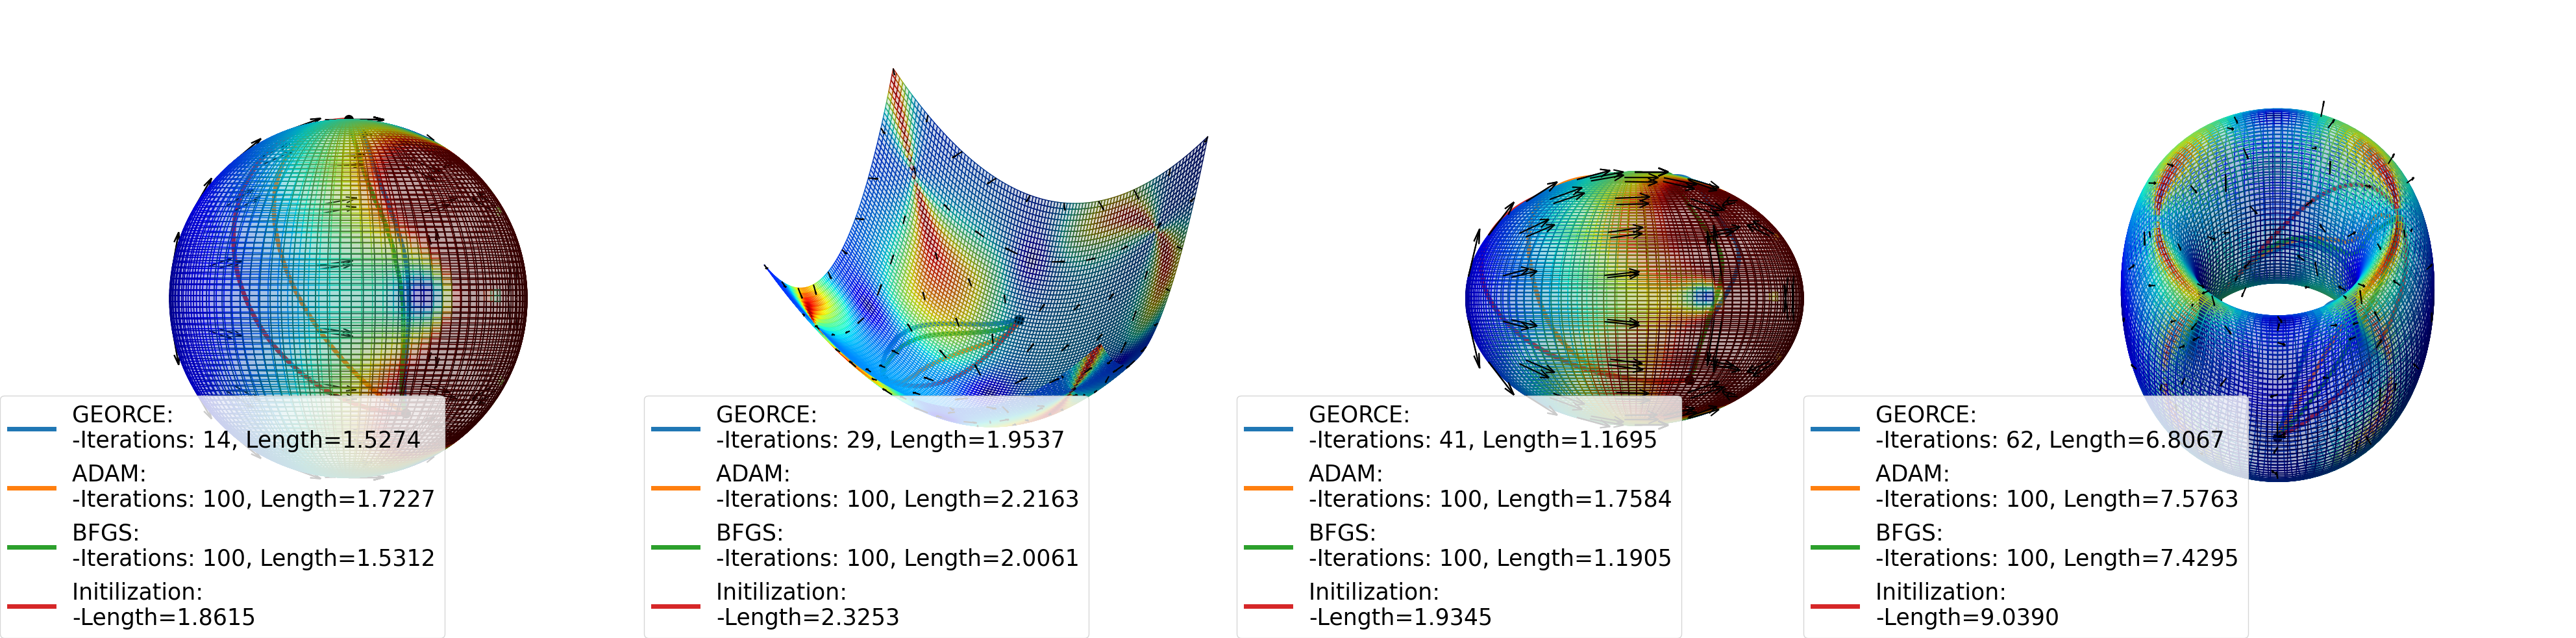

In [24]:
fig = plt.figure(figsize=(40,10))

#plotting sphere
plot_sphere = EllipsoidPlot(params=jnp.ones(3))
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(141, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
for key, value in sphere_methods.items():
    if value['idx'] is not None:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
            label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
    else:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

    
ax.scatter(s2_x0[0], s2_x0[1], s2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(s2_xT[0], s2_xT[1], s2_xT[2], color='black', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
ax.set_xlim([-1.0,1.0])
ax.set_ylim([-1.0,1.0])
ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.0,0.0), ncol=1)

#plotting paraboloid
plot_sphere = ParaboloidPlot()
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(100)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(142, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
for key, value in paraboloid_methods.items():
    if value['idx'] is not None:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
            label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
    else:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

    
ax.scatter(p2_x0[0], p2_x0[1], p2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(p2_xT[0], p2_xT[1], p2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=40., azim=110.)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.25,0.0), ncol=1)

#plotting Ellipsoid
plot_sphere = EllipsoidPlot()
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(x1,x2,x3)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(143, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
for key, value in ellipsoid_methods.items():
    if value['idx'] is not None:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
            label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
    else:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

    
ax.scatter(e2_x0[0], e2_x0[1], e2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(e2_xT[0], e2_xT[1], e2_xT[2], color='black', alpha=1.0, s=100)
#ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=180., azim=90)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.48, 0.0), ncol=1)

#plotting Torus
plot_sphere = TorusPlot(R=3.0, r=1.0)
x1,x2,x3 = plot_sphere.grid(100)
heat_map = plot_sphere.heat_map(100)
field = plot_sphere.unit_direction(10)
ax = fig.add_subplot(144, projection='3d')
ax.plot_surface(x1, x2, x3, rstride=1, cstride=1, alpha=0.2,
               facecolors=plt.cm.jet(heat_map))
ax.quiver(field[0], field[1], field[2], 
          field[-1][:,:,0], field[-1][:,:,1], field[-1][:,:,2], color='black', length=0.2, normalize=True)
for key, value in torus_methods.items():
    if value['idx'] is not None:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
            label=f"{key}: \n-Iterations: {value['idx']}, Length={value['length']:.4f}", linewidth=5.0)
    else:
        ax.plot(value['xt'][:,0], value['xt'][:,1], value['xt'][:,2], alpha=1.0, 
                label=f"{key}: \n-Length={value['length']:.4f}", linewidth=5.0)

    
ax.scatter(t2_x0[0], t2_x0[1], t2_x0[2], color='black', alpha=1.0, s=100)
ax.scatter(t2_xT[0], t2_xT[1], t2_xT[2], color='black', alpha=1.0, s=100)
ax.set_box_aspect([1,1,1])
#ax.set_xlim([-1.0,1.0])
#ax.set_ylim([-1.0,1.0])
#ax.set_zlim([-1.0,1.0])
ax.set_axis_off()
ax.view_init(elev=60., azim=0)
lines_labels = [ax.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.70, 0.0), ncol=1)

fig.tight_layout()

save_path = f'{figure_path}synthetic_finsler_geodesics.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()




## Plotting Gradients

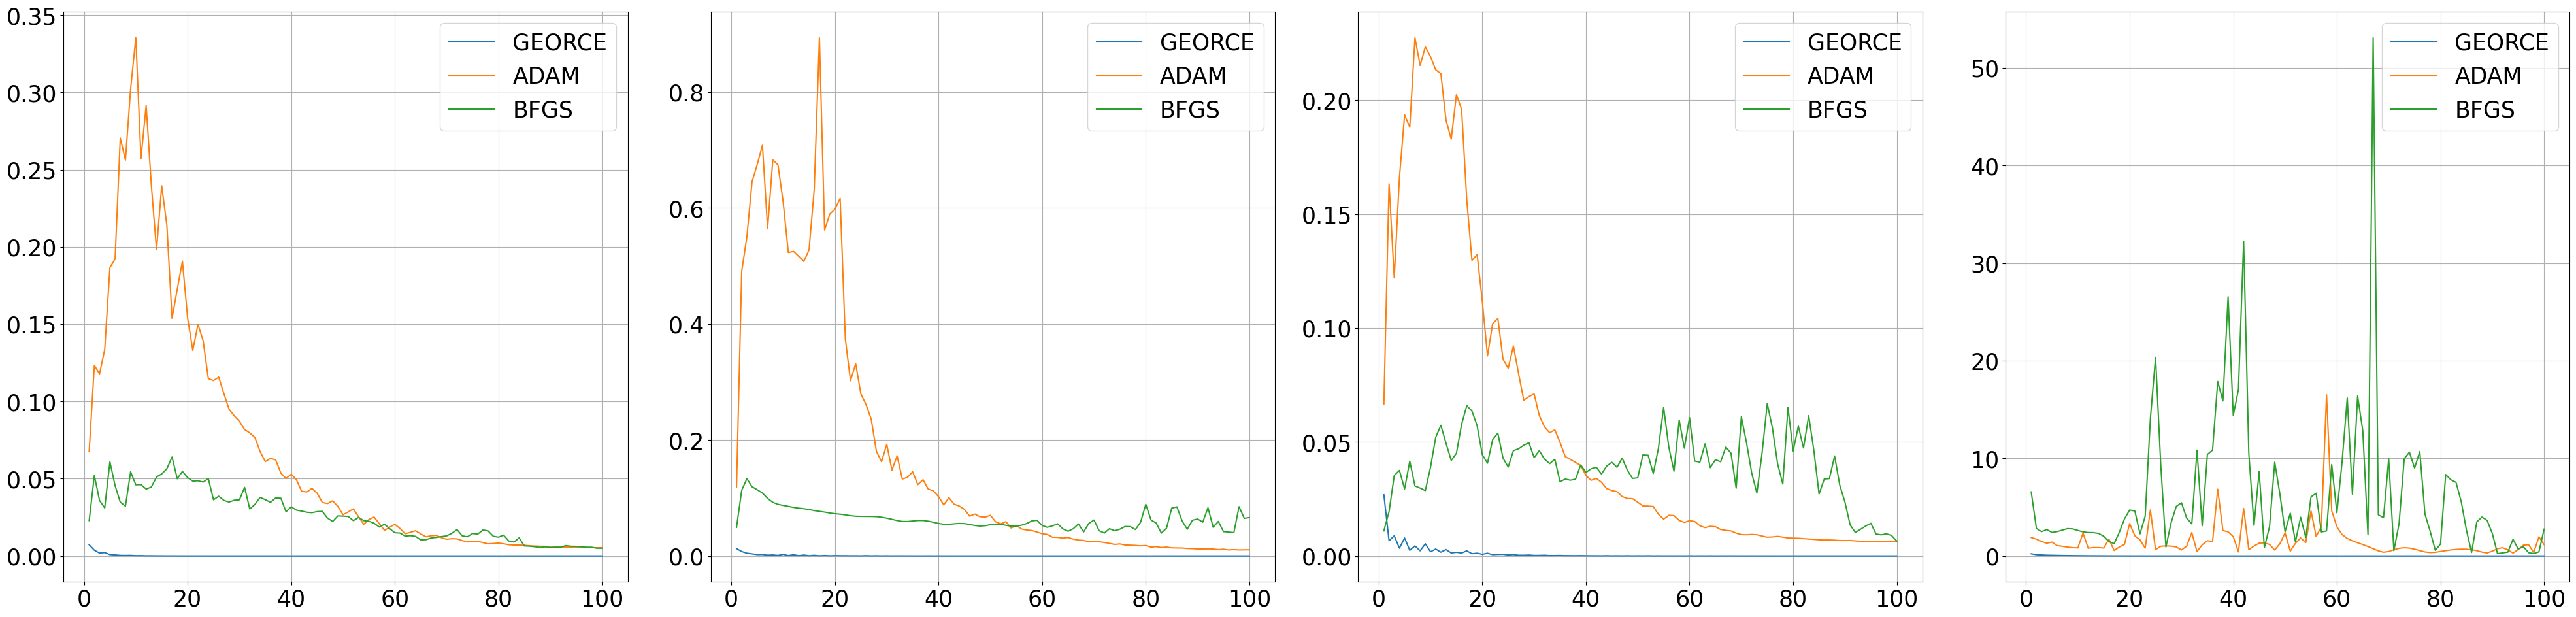

In [25]:
fig = plt.figure(figsize=(40,10))

ax = fig.add_subplot(141)
for key, value in sphere_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(142)
for key, value in paraboloid_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(143)
for key, value in ellipsoid_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

ax = fig.add_subplot(144)
for key, value in torus_methods.items():
    if value['grad'] is not None:
        ax.plot(jnp.arange(1,len(value['grad_curve'])+1,1), value['grad_curve'], 
                alpha=1.0, label=f"{key}")
ax.grid(True)
ax.legend(loc='upper right')

fig.tight_layout()

save_path = f'{figure_path}synthetic_finsler_gradients.pdf'
fig.savefig(save_path, format='pdf', pad_inches=0.1, bbox_inches='tight')

plt.show()

